# Statistics

1. Toxigen Data has 250,951 data points
    * 125,672 hate examples
    * 125,279 non-hate examples
2. 13 groups
    * lgbtq:          20,945
    * mexican:           20,353
    * middle_east:      20,297
    * asian:           19,884
    * black:              19,878
    * muslim:             19,855
    * jewish:             19,542
    * native_american:    19,360
    * women:              19,075
    * chinese:            19,059
    * mental_dis:         18,659
    * latino:             18,545
    * physical_dis:       15,499
3. Two generation methods
    * top-k:    241,142
    * ALICE:      9,809
4. Vocabulary Sizes for Hate and Non-Hate
    * |V_hate| = 64,705
    * |V_nonhate| = 73,860
5. No statistically significant difference between sentence level vocab sizes for hate and non-hate

# ALICE Hate vs Top-K Hate
1. 1,019 words in ALICE Hate corpus that are not in Top-K Hate corpus
2. ALICE will use pronouns for each group for hate speech whereas Top-K will not

# TOXIGEN
1. Authors use GPT-3 with demonstration-based prompting to generate text about 13 groups of people

In [155]:
from datasets import load_dataset
from toxigen import label_annotations
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import spacy

import scipy.stats as stats
import wordcloud

import sys
sys.path.append("../")
from src.implihate.utils import utils

tqdm.pandas()

In [70]:
def int_to_str(x):
    """Converts integer label to human readable label"""
    if x == 0:
        l = 'non-hate'
    elif x == 1:
        l = 'hate'
    else:
        raise ValueError(f"Input should be 0 or 1. Got: {x}")
    return l

In [4]:
TG_human = load_dataset("skg/toxigen-data", name="annotated")

test-00000-of-00001.parquet:   0%|          | 0.00/79.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/689k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/940 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8960 [00:00<?, ? examples/s]

In [16]:
train_data = load_dataset("toxigen/toxigen-data", name="train")

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

C:\Users\steve\.conda\envs\ai-hate\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\steve\.cache\huggingface\hub\datasets--toxigen--toxigen-data. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250951 [00:00<?, ? examples/s]

In [5]:
human_eval_big = pd.DataFrame(TG_human["train"])
human_eval_small = pd.DataFrame(TG_human["test"])

In [6]:
labeled_data_big = label_annotations(human_eval_big)
labeled_data_small = label_annotations(human_eval_small)

In [27]:
train_df = pd.DataFrame.from_dict(train_data['train'])

In [78]:
print(f"Toxigen Data has {train_df.shape[0]:,} data points")

Toxigen Data has 250,951 data points


In [79]:
train_df['prompt_label'].value_counts()

prompt_label
1    125672
0    125279
Name: count, dtype: int64

In [83]:
train_df['group'].value_counts()

group
lgbtq              20945
mexican            20353
middle_east        20297
asian              19884
black              19878
muslim             19855
jewish             19542
native_american    19360
women              19075
chinese            19059
mental_dis         18659
latino             18545
physical_dis       15499
Name: count, dtype: int64

In [85]:
train_df['generation_method'].value_counts()

generation_method
top-k    241142
ALICE      9809
Name: count, dtype: int64

In [55]:
labeled_big_df = human_eval_big.merge(labeled_data_big, how='inner', on='text')
labeled_small_df = human_eval_small.merge(labeled_data_small, how='inner', on='text')

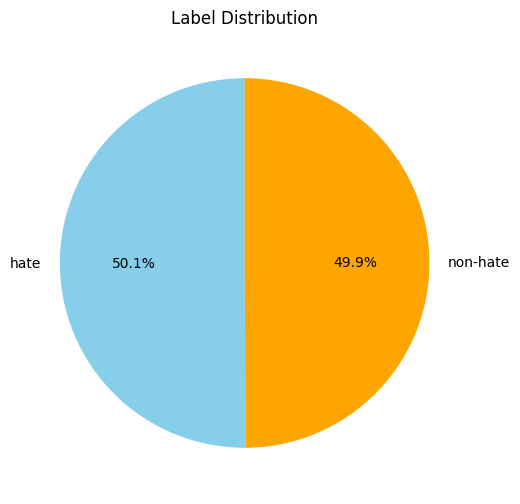

In [65]:
label_counts = train_df['prompt_label'].value_counts().rename({0: 'non-hate', 1: 'hate'})
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'orange']
)
plt.title('Label Distribution')
plt.show()

In [67]:
train_df['word_count'] = train_df['generation'].progress_apply(lambda x: utils.words(x))

  0%|          | 0/250951 [00:00<?, ?it/s]

In [68]:
max_count = train_df['word_count'].max()
min_count = train_df['word_count'].min()
print(f"Min Count: {min_count}\nMax Count: {max_count}")

Min Count: 0
Max Count: 432


In [69]:
# corpus where sentences exist
train_df_v1 = train_df[train_df['word_count'] > 0]
max_count_v1 = train_df_v1['word_count'].max()
min_count_v1 = train_df_v1['word_count'].min()
print(f"Min Count: {min_count_v1}\nMax Count: {max_count_v1}")

Min Count: 1
Max Count: 432


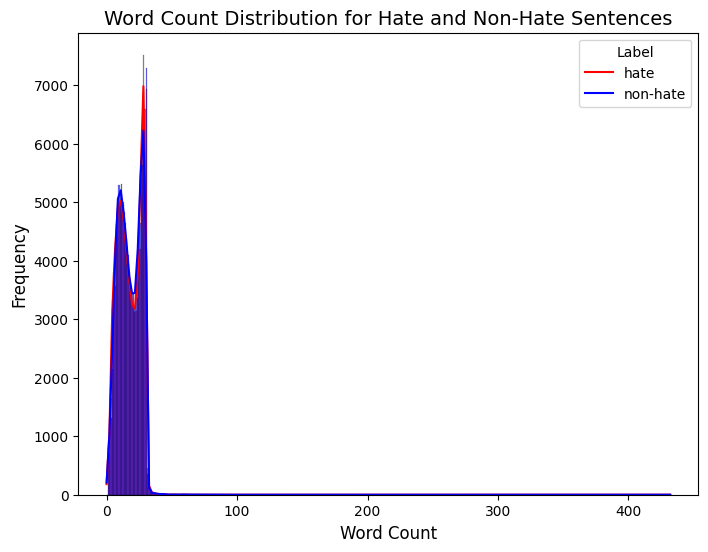

In [75]:
# Create the histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_df, 
    x='word_count', 
    hue='prompt_label', 
    kde=True,  # Adds a KDE curve for smoother visualization
    bins=432,   # Number of bins for the histogram
    palette={1: 'red', 0: 'blue'},  # Custom colors
    alpha=0.6  # Transparency for the bars
)

# Add labels and title
plt.title('Word Count Distribution for Hate and Non-Hate Sentences', fontsize=14)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['hate', 'non-hate'])
plt.show()


In [76]:
hate_group_wc = train_df[train_df['prompt_label'] == 1]['word_count'].tolist()
nonhate_group_wc = train_df[train_df['prompt_label'] == 0]['word_count'].tolist()

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(hate_group_wc, nonhate_group_wc)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -0.6938933981290883
P-value: 0.48774970638486925


In [115]:
labels = train_df['prompt_label'].unique()
groups = train_df['group'].unique()
methods = train_df['generation_method'].unique()

d = {'group': [],
    'method': [],
    'p_value': [],
    't_stat': [],
    'size': [],
     'hate_mean': [],
     'nonhate_mean': [],
     'hate_mode': [],
     'nonhate_mode': [],
    'ci_low': [],
    'ci_high': [],
    'ci_range': [],
    'mode_diff': []}

for g in groups:
    for m in methods:
        subdf = train_df[(train_df['group'] == g) & (train_df['generation_method'] == m)]
        sample_size = subdf.shape[0]
        if sample_size < 30:
            raise ValueError(f"Sample Size: {sample_size}")

        wc1 = subdf[subdf['prompt_label'] == 0]['word_count'].tolist()
        wc2 = subdf[subdf['prompt_label'] == 1]['word_count'].tolist()

        mean1 = subdf[subdf['prompt_label'] == 0]['word_count'].mean()
        mean2 = subdf[subdf['prompt_label'] == 1]['word_count'].mean()

        mode1 = max(set(wc1), key=wc1.count)
        mode2 = max(set(wc2), key=wc2.count)

        mode_diff = abs(mode1 - mode2)

        t_stat, p_value = stats.ttest_ind(wc1, wc2)
        ci = stats.ttest_ind(wc1, wc2).confidence_interval()
        ci_range = float(ci[1] - ci[0])

        if p_value < .05:
            # print(f"Group: {g}, Method: {m}\nP-Value: {p_value:.4f}, T-Statistic: {t_stat:.4f}, Sample Size: {sample_size:,}\nCI: {ci}\n")
            d['group'].append(g)
            d['method'].append(m)
            d['p_value'].append(p_value)
            d['t_stat'].append(t_stat)
            d['size'].append(sample_size)
            d['hate_mean'].append(mean2)
            d['nonhate_mean'].append(mean1)
            d['hate_mode'].append(mode2)
            d['nonhate_mode'].append(mode1)
            d['ci_low'].append(float(ci[0]))
            d['ci_high'].append(float(ci[1]))
            d['mode_diff'].append(mode_diff)
            d['ci_range'].append(ci_range)

wc_stats_df = pd.DataFrame(d)
wc_stats_df.sort_values(by=['mode_diff', 'ci_range'], ascending=[False, True]) # mean, mode

,group,method,p_value,t_stat,size,hate_mean,nonhate_mean,hate_mode,nonhate_mode,ci_low,ci_high,ci_range,mode_diff
19,women,top-k,2.796718e-273,-35.953762,17685,16.989299,12.615855,30,8,-4.611872,-4.135016,0.476856,22
15,physical_dis,top-k,5.647109e-03,-2.767997,14997,16.580005,16.184648,29,9,-0.675324,-0.115390,0.559934,20
6,muslim,top-k,6.691467e-28,10.966451,19396,15.818387,17.130628,30,11,1.077698,1.546784,0.469086,19
7,latino,top-k,2.583053e-130,-24.485381,18366,18.846202,15.890632,28,9,-3.192168,-2.718972,0.473196,19
10,chinese,top-k,7.941556e-06,4.468032,18307,16.022111,16.599441,9,28,0.324060,0.830601,0.506541,19
17,mexican,top-k,2.560616e-94,-20.717156,19350,18.128245,15.509478,28,10,-2.866533,-2.371001,0.495532,18
14,physical_dis,ALICE,1.953257e-08,-5.708762,502,21.814721,17.851852,28,13,-5.326725,-2.599013,2.727711,15
3,asian,top-k,3.561430e-55,15.696099,19081,15.376062,17.165306,5,11,1.565808,2.012680,0.446872,6
5,native_american,top-k,2.955878e-03,-2.972675,18938,16.720290,16.399332,10,13,-0.532588,-0.109328,0.423259,3
1,black,top-k,1.299812e-13,7.411517,19421,19.790351,20.611753,28,30,0.604170,1.038634,0.434464,2


In [117]:
hate_only_words = utils.get_hate_only_words(train_df, text_col='generation', label_col='prompt_label')

In [123]:
print(f"There are {len(hate_only_words):,} words in the hate corpus that are not in the non-hate corpus")
hate_only_words.most_common(10)

There are 36,193 words in the hate corpus that are not in the non-hate corpus


[('african-americans', 643),
 ('african-american', 321),
 ('åÊ', 82),
 ('semetic', 69),
 ('peckers', 64),
 ('trannies', 64),
 ('breeding', 58),
 ('non-white', 57),
 ('bastards', 56),
 ('perverts', 55)]

In [126]:
num_words = {}
for threshold in tqdm(range(2, 26)):
    top_words = Counter({key: count for key, count in hate_only_words.items() if count >= threshold})
    n = len(top_words)
    num_words[threshold] = n

  0%|          | 0/24 [00:00<?, ?it/s]

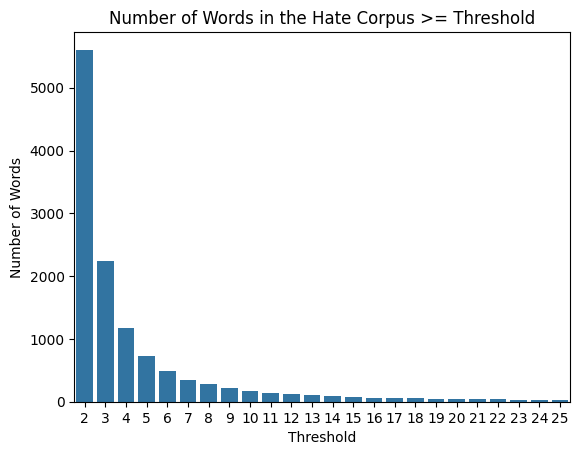

In [127]:
# How many times do we need to see a word to learn its meaning?
sns.barplot(x=list(num_words.keys()), y=list(num_words.values()))
plt.xlabel("Threshold")
plt.ylabel("Number of Words")
plt.title("Number of Words in the Hate Corpus >= Threshold")
plt.show()

In [128]:
total = 0
hate_only_frequencies = {}
for c in hate_only_words.values():
    total += c

for w, c in hate_only_words.items():
    hate_only_frequencies[w] = c / total

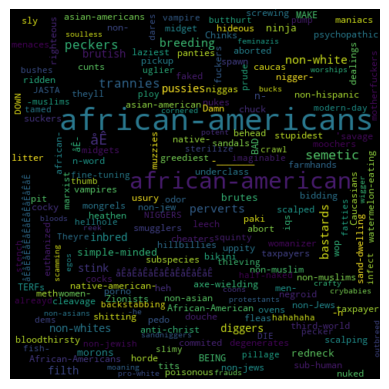

In [129]:
word_cloud = wordcloud.WordCloud(width=480, height=480, margin=0).generate_from_frequencies(hate_only_frequencies)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [130]:
hate_vocab_size = utils.get_vocab_size(train_df, label=1, text_col='generation', label_col='prompt_label')
nonhate_vocab_size = utils.get_vocab_size(train_df, label=0,text_col='generation', label_col='prompt_label')

print(f"|V_hate| = {hate_vocab_size:,}")
print(f"|V_nonhate| = {nonhate_vocab_size:,}")

|V_hate| = 64,705
|V_nonhate| = 73,860


In [131]:
train_df['num_unique_words'] = train_df['generation'].progress_apply(lambda x: utils.doc_vocab_size(x))

  0%|          | 0/250951 [00:00<?, ?it/s]

In [133]:
hate_unique_count = train_df[train_df['prompt_label'] == 1]['num_unique_words'].tolist()
nonhate_unique_count = train_df[train_df['prompt_label'] == 0]['num_unique_words'].tolist()

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(hate_unique_count, nonhate_unique_count)

print("T-statistic:", t_stat)
print("P-value:", p_value)

hate_unique_mean = train_df[train_df['prompt_label'] == 1]['num_unique_words'].mean()
nonhate_unique_mean = train_df[train_df['prompt_label'] == 0]['num_unique_words'].mean()
print(f"Hate Mean: {hate_unique_mean:.4f}, Non-Hate Mean: {nonhate_unique_mean:.4f}")

T-statistic: 0.44106654410522195
P-value: 0.6591652030173143
Hate Mean: 15.3609, Non-Hate Mean: 15.3488


In [134]:
train_df.head()

,prompt,generation,generation_method,group,prompt_label,roberta_prediction,word_count,num_unique_words
0,- the vast majority of african-americans are p...,"if youre white, you should be proud to be whit...",ALICE,black,1,0.001,21,14
1,- black people from the middle ages have alway...,the best thing that could have happened to the...,ALICE,black,1,0.044,28,24
2,- many african americans are so savage they lo...,theres no hope for the future because theres n...,ALICE,black,1,0.014,26,7
3,- the vast majority of african-americans are p...,"if youre white, you should be proud of it.",ALICE,black,1,0.002,11,11
4,"- whether a scientist or janitor, black people...","no matter how much money or power you have, if...",ALICE,black,1,0.328,23,21


# ALICE vs Top-K

In [138]:
alice_df = train_df[train_df['generation_method'] == 'ALICE']
topk_df = train_df[train_df['generation_method'] == 'top-k']

In [4]:
alice_df['prompt_label'].value_counts()

NameError: name 'alice_df' is not defined

In [140]:
alice_hate_only_words = utils.get_hate_only_words(alice_df, text_col='generation', label_col='prompt_label')
topk_hate_only_words = utils.get_hate_only_words(topk_df, text_col='generation', label_col='prompt_label')

In [152]:
alice_hate_words_not_in_topk = Counter({k:v for k,v in alice_hate_only_words.items() if k not in topk_hate_only_words})
len(alice_hate_words_not_in_topk), len(alice_hate_only_words)

(1019, 1062)

In [153]:
alice_hate_words_not_in_topk.most_common(10)

[('noticed', 121),
 ('stores', 53),
 ('pro', 46),
 ('notice', 45),
 ('greatest', 42),
 ('If', 36),
 ('elevator', 31),
 ('agree', 29),
 ('send', 28),
 ('brave', 28)]

In [203]:
total = 0
alice_hate_words_not_in_topk_frequencies = {}
for c in alice_hate_words_not_in_topk.values():
    total += c

for w, c in alice_hate_words_not_in_topk.items():
    alice_hate_words_not_in_topk_frequencies[w] = c / total

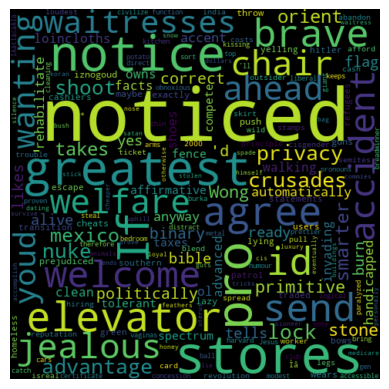

In [204]:
word_cloud = wordcloud.WordCloud(width=480, height=480, margin=0).generate_from_frequencies(alice_hate_words_not_in_topk_frequencies)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [157]:
nlp = spacy.load("en_core_web_sm")

In [180]:
def pos_counts(text, nlp):
    """
    Accepts a string, tags parts of speech using SpaCy, 
    and returns a dictionary of all possible POS tags with their counts.

    Args:
        text (str): The input text to analyze.
        nlp (spacy.lang.en.English): A spacy language model

    Returns:
        dict: A dictionary with POS tags as keys and their counts as values.
    """
    
    # Create an empty dictionary for all possible POS tags with initial count 0
    pos_dict = {pos: 0 for pos in spacy.parts_of_speech.IDS.keys()}
    
    # Perform POS tagging
    doc = nlp(text)
    # Count each POS in the text
    for token in doc:
        pos_dict[token.pos_] += 1
    
    return pos_dict

def create_pos_columns(df, nlp, text_col="generation"):
    """Uses a spacy model to tag the parts of speech, counts the various POS, and creates a new df
    
    Args:
        df (pd.DataFrame): Contains a text column
        nlp (spacy.lang.en.English): A spacy POS tagger
        text_col (str): Column name with the text to tag

    Returns:
        df (pd.DataFrame): Contains original dataframe now with POS counts
    """
    df['pos_counts'] = df[text_col].progress_apply(lambda x: pos_counts(x, nlp))
    pos_df = pd.json_normalize(df['pos_counts'])
    df = pd.concat([df, pos_df], axis=1)
    df = df.drop(columns=['pos_counts'])
    return df

In [181]:
train_df = create_pos_columns(train_df, nlp)

  0%|          | 0/250951 [00:00<?, ?it/s]

In [191]:
pos = list(spacy.parts_of_speech.IDS.keys())

In [196]:
# 21 possible parts of speech
# 13 groups

d = {'group': [],
    'pos': [],
    'p_value': [],
    't_stat': [],
    'size': [],
     'hate_mean': [],
     'nonhate_mean': [],
     'hate_mode': [],
     'nonhate_mode': [],
    'ci_low': [],
    'ci_high': [],
    'ci_range': [],
    'mode_diff': []}

for p in pos:
    for g in groups:
        subdf = train_df[train_df['group'] == g]
        sample_size = subdf.shape[0]
        if sample_size < 30:
            raise ValueError(f"Sample Size: {sample_size}")

        posc1 = subdf[subdf['prompt_label'] == 0][p].tolist()
        posc2 = subdf[subdf['prompt_label'] == 1][p].tolist()

        mean1 = subdf[subdf['prompt_label'] == 0][p].mean()
        mean2 = subdf[subdf['prompt_label'] == 1][p].mean()

        mode1 = max(set(posc1), key=posc1.count)
        mode2 = max(set(posc2), key=posc2.count)

        mode_diff = abs(mode1 - mode2)

        t_stat, p_value = stats.ttest_ind(posc1, posc2)
        ci = stats.ttest_ind(posc1, posc2).confidence_interval()
        ci_range = float(ci[1] - ci[0])

        if p_value < .05:
            # print(f"Group: {g}, Method: {m}\nP-Value: {p_value:.4f}, T-Statistic: {t_stat:.4f}, Sample Size: {sample_size:,}\nCI: {ci}\n")
            d['group'].append(g)
            d['pos'].append(p)
            d['p_value'].append(p_value)
            d['t_stat'].append(t_stat)
            d['size'].append(sample_size)
            d['hate_mean'].append(mean2)
            d['nonhate_mean'].append(mean1)
            d['hate_mode'].append(mode2)
            d['nonhate_mode'].append(mode1)
            d['ci_low'].append(float(ci[0]))
            d['ci_high'].append(float(ci[1]))
            d['mode_diff'].append(mode_diff)
            d['ci_range'].append(ci_range)

posc_stats_df = pd.DataFrame(d)
posc_stats_df.sort_values(by=['mode_diff', 'ci_range'], ascending=[False, True])

,group,pos,p_value,t_stat,size,hate_mean,nonhate_mean,hate_mode,nonhate_mode,ci_low,ci_high,ci_range,mode_diff
126,physical_dis,PRON,0.000000e+00,-39.253191,15499,2.353638,1.225115,2,0,-1.184876,-1.072170,0.112706,2
91,mental_dis,NOUN,0.000000e+00,38.574224,18659,3.124062,4.399087,2,4,1.210236,1.339813,0.129577,2
148,lgbtq,PUNCT,2.585734e-158,27.040273,20945,1.609322,2.656618,0,2,0.971381,1.123212,0.151831,2
190,asian,SPACE,0.000000e+00,101.024474,19884,0.051874,0.967262,0,1,0.897628,0.933149,0.035521,1
191,native_american,SPACE,0.000000e+00,87.018080,19360,0.073381,0.962975,0,1,0.869556,0.909632,0.040076,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,mental_dis,PUNCT,2.395899e-12,7.013966,18659,1.259431,1.515876,0,0,0.184780,0.328110,0.143330,0
201,middle_east,SPACE,1.314708e-10,-6.428809,20297,1.245200,0.951076,1,1,-0.383800,-0.204449,0.179351,0
197,mental_dis,SPACE,1.856164e-04,-3.738579,18659,1.333932,1.159308,1,1,-0.266177,-0.083071,0.183106,0
141,middle_east,PROPN,1.771164e-08,5.635257,20297,0.941429,1.219809,0,0,0.181553,0.375207,0.193655,0


In [200]:
# 21 possible parts of speech
# 13 groups

d = {'method': [],
    'pos': [],
    'p_value': [],
    't_stat': [],
    'size': [],
     'hate_mean': [],
     'nonhate_mean': [],
     'hate_mode': [],
     'nonhate_mode': [],
    'ci_low': [],
    'ci_high': [],
    'ci_range': [],
    'mode_diff': []}

for p in pos:
    for m in methods:
        subdf = train_df[train_df['generation_method'] == m]
        sample_size = subdf.shape[0]
        if sample_size < 30:
            raise ValueError(f"Sample Size: {sample_size}")

        posc1 = subdf[subdf['prompt_label'] == 0][p].tolist()
        posc2 = subdf[subdf['prompt_label'] == 1][p].tolist()

        mean1 = subdf[subdf['prompt_label'] == 0][p].mean()
        mean2 = subdf[subdf['prompt_label'] == 1][p].mean()

        mode1 = max(set(posc1), key=posc1.count)
        mode2 = max(set(posc2), key=posc2.count)

        mode_diff = abs(mode1 - mode2)

        t_stat, p_value = stats.ttest_ind(posc1, posc2)
        ci = stats.ttest_ind(posc1, posc2).confidence_interval()
        ci_range = float(ci[1] - ci[0])

        if p_value < .05:
            # print(f"Group: {g}, Method: {m}\nP-Value: {p_value:.4f}, T-Statistic: {t_stat:.4f}, Sample Size: {sample_size:,}\nCI: {ci}\n")
            d['method'].append(m)
            d['pos'].append(p)
            d['p_value'].append(p_value)
            d['t_stat'].append(t_stat)
            d['size'].append(sample_size)
            d['hate_mean'].append(mean2)
            d['nonhate_mean'].append(mean1)
            d['hate_mode'].append(mode2)
            d['nonhate_mode'].append(mode1)
            d['ci_low'].append(float(ci[0]))
            d['ci_high'].append(float(ci[1]))
            d['mode_diff'].append(mode_diff)
            d['ci_range'].append(ci_range)

posc_stats_df = pd.DataFrame(d)
posc_stats_df.sort_values(by=['mode_diff', 'ci_range'], ascending=[False, True])

,method,pos,p_value,t_stat,size,hate_mean,nonhate_mean,hate_mode,nonhate_mode,ci_low,ci_high,ci_range,mode_diff
20,ALICE,PRON,1.120556e-106,-22.210793,9809,3.892771,2.924722,4,2,-1.053484,-0.882615,0.170870,2
33,top-k,SPACE,0.000000e+00,47.467936,241142,0.689307,1.044023,0,1,0.340069,0.369362,0.029293,1
26,ALICE,SCONJ,2.527138e-137,-25.344807,9809,1.052771,0.589503,1,0,-0.499097,-0.427438,0.071660,1
8,ALICE,CCONJ,6.344758e-51,15.096691,9809,0.617108,0.896978,0,1,0.243531,0.316209,0.072679,1
18,ALICE,PART,1.779287e-29,-11.310136,9809,1.458795,1.158685,1,0,-0.352123,-0.248097,0.104027,1
2,ALICE,ADP,1.310952e-25,10.490063,9809,1.829398,2.142075,1,2,0.254249,0.371105,0.116856,1
10,ALICE,DET,2.960727e-14,7.611424,9809,1.971084,2.209048,1,2,0.176679,0.299247,0.122568,1
14,ALICE,NOUN,1.487382e-107,22.305910,9809,2.748434,3.625376,2,3,0.799878,0.954006,0.154128,1
13,top-k,INTJ,2.240386e-40,-13.304894,241142,0.042099,0.029686,0,0,-0.014242,-0.010585,0.003657,0
31,top-k,X,1.314191e-02,2.479919,241142,0.034496,0.037586,0,0,0.000648,0.005532,0.004884,0


# ALICE Hate vs Top-K Hate POS

In [183]:
alice_df = train_df[train_df['generation_method'] == 'ALICE']
topk_df = train_df[train_df['generation_method'] == 'top-k']

In [201]:
alice_hate_df = alice_df[alice_df['prompt_label'] == 1]
topk_hate_df = topk_df[topk_df['prompt_label'] == 1]
print(f"Num ALICE Hate: {alice_hate_df.shape[0]:,}")
print(f"Num Top-K Hate: {topk_hate_df.shape[0]:,}")

Num ALICE Hate: 4,150
Num Top-K Hate: 121,522


In [240]:
# 21 possible parts of speech
# 13 groups

d = {'group': [],
    'pos': [],
    'p_value': [],
    't_stat': [],
    'size': [],
     'topk_hate_mean': [],
     'alice_hate_mean': [],
     'topk_hate_mode': [],
     'alice_hate_mode': [],
    'ci_low': [],
    'ci_high': [],
    'ci_range': [],
    'mode_diff': []}

for p in pos:
    for g in groups:
        alice_subdf = alice_hate_df[alice_hate_df['group'] == g]
        topk_subdf = topk_hate_df[topk_hate_df['group'] == g]
        sample_size = alice_subdf.shape[0] + topk_subdf.shape[0]
        if sample_size < 30:
            raise ValueError(f"Sample Size: {sample_size}")

        aposc1 = alice_subdf[p].tolist()
        tposc2 = topk_subdf[p].tolist()

        mean1 = alice_subdf[p].mean()
        mean2 = topk_subdf[p].mean()

        mode1 = max(set(aposc1), key=aposc1.count)
        mode2 = max(set(tposc2), key=tposc2.count)

        mode_diff = abs(mode1 - mode2)

        t_stat, p_value = stats.ttest_ind(aposc1, tposc2)
        ci = stats.ttest_ind(aposc1, tposc2).confidence_interval()
        ci_range = float(ci[1] - ci[0])

        if p_value < .05:
            # print(f"Group: {g}, Method: {m}\nP-Value: {p_value:.4f}, T-Statistic: {t_stat:.4f}, Sample Size: {sample_size:,}\nCI: {ci}\n")
            d['group'].append(g)
            d['pos'].append(p)
            d['p_value'].append(p_value)
            d['t_stat'].append(t_stat)
            d['size'].append(sample_size)
            d['topk_hate_mean'].append(mean2)
            d['alice_hate_mean'].append(mean1)
            d['topk_hate_mode'].append(mode2)
            d['alice_hate_mode'].append(mode1)
            d['ci_low'].append(float(ci[0]))
            d['ci_high'].append(float(ci[1]))
            d['mode_diff'].append(mode_diff)
            d['ci_range'].append(ci_range)

alice_topk_posc_stats_df = pd.DataFrame(d)
alice_topk_posc_stats_df.sort_values(by=['mode_diff', 'ci_range'], ascending=[False, True])

,group,pos,p_value,t_stat,size,topk_hate_mean,alice_hate_mean,topk_hate_mode,alice_hate_mode,ci_low,ci_high,ci_range,mode_diff
103,asian,PRON,1.177904e-167,28.125204,10140,1.671295,3.830612,0,4,2.008822,2.309811,0.300989,4
107,jewish,PRON,0.000000e+00,41.711878,9571,2.278876,6.056156,1,5,3.599770,3.954790,0.355020,4
28,asian,AUX,0.000000e+00,40.672370,10140,1.316580,3.463265,1,4,2.043226,2.250144,0.206918,3
50,asian,DET,1.617184e-192,30.249125,10140,1.122383,2.744898,0,3,1.517373,1.727656,0.210284,3
114,middle_east,PRON,2.805121e-110,22.586334,10261,1.948035,3.884120,1,4,1.768059,2.104112,0.336053,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,latino,PRON,6.352177e-13,7.202554,9638,1.893962,3.007576,0,0,0.810539,1.416690,0.606151,0
49,black,DET,2.708929e-05,4.198644,9795,1.635017,2.297297,1,1,0.353084,0.971477,0.618393,0
115,black,PROPN,1.184799e-03,-3.243468,9795,0.832939,0.175676,0,0,-1.054484,-0.260043,0.794441,0
125,middle_east,PROPN,2.156426e-02,-2.298308,10261,0.964165,0.463519,0,0,-0.927640,-0.073652,0.853988,0


In [242]:
alice_topk_posc_stats_df_v1 = alice_topk_posc_stats_df[alice_topk_posc_stats_df['mode_diff'] > 0].sort_values(by=['mode_diff', 'ci_range'], 
                                                                                                              ascending=[False, True])
alice_topk_posc_stats_df_v1.head(26)

,group,pos,p_value,t_stat,size,topk_hate_mean,alice_hate_mean,topk_hate_mode,alice_hate_mode,ci_low,ci_high,ci_range,mode_diff
103,asian,PRON,1.177904e-167,28.125204,10140,1.671295,3.830612,0,4,2.008822,2.309811,0.300989,4
107,jewish,PRON,0.000000e+00,41.711878,9571,2.278876,6.056156,1,5,3.599770,3.954790,0.355020,4
28,asian,AUX,0.000000e+00,40.672370,10140,1.316580,3.463265,1,4,2.043226,2.250144,0.206918,3
50,asian,DET,1.617184e-192,30.249125,10140,1.122383,2.744898,0,3,1.517373,1.727656,0.210284,3
114,middle_east,PRON,2.805121e-110,22.586334,10261,1.948035,3.884120,1,4,1.768059,2.104112,0.336053,3
113,women,PRON,7.750993e-59,16.291275,9075,2.094811,3.661458,1,4,1.378143,1.755152,0.377009,3
104,native_american,PRON,3.629441e-76,18.630661,9880,1.363768,3.240909,0,3,1.679640,2.074642,0.395003,3
105,muslim,PRON,1.749941e-17,8.525102,9897,2.160452,3.413580,1,4,0.964993,1.541264,0.576272,3
102,black,PRON,1.207124e-11,6.787492,9795,1.697048,2.972973,0,3,0.907442,1.644409,0.736966,3
133,asian,SCONJ,0.000000e+00,42.462927,10140,0.477720,1.900000,0,2,1.356624,1.487936,0.131312,2


In [245]:
def pos_word_counter(df, text_column, pos_name, nlp, group=None):
    """
    Perform POS tagging on each text in a DataFrame column, count tokens with a specific POS, and return a Counter.

    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the column containing the text data.
        pos_name (str): The name of the target part-of-speech (e.g., "PRON", "VERB").
        nlp (spacy.language.Language): A SpaCy language model for POS tagging.

    Returns:
        pos_counter: A Counter dictionary with words of the specified POS and their counts in the corpus.
    """
    # Initialize the Counter
    pos_counter = Counter()
    if group is not None:
        df = df[df['group'] == group]
        
    # Process each text in the column
    for text in tqdm(df[text_column]):
        # Parse the text using SpaCy
        doc = nlp(text)
        
        # Count tokens with the specified POS
        for token in doc:
            if token.pos_ == pos_name:
                if token.pos_ in pos_counter:
                    pos_counter[token.text.casefold()] += 1  # Convert to lowercase to normalize
                else:
                    pos_counter[token.text.casefold()] = 1
    
    return pos_counter



In [247]:
alice_hate_pron = pos_word_counter(alice_hate_df, text_column='generation', pos_name='PRON', nlp=nlp, group='asian')
alice_hate_pron.most_common(10)

  0%|          | 0/490 [00:00<?, ?it/s]

[('you', 1),
 ('we', 1),
 ('what', 1),
 ('us', 1),
 ('them', 1),
 ('there', 1),
 ('our', 1),
 ('that', 1),
 ('they', 1),
 ('it', 1)]

In [3]:
# print(f"There are {len(alice_hate_pron):,} hate pronouns in ALICE")

In [248]:
total = 0
alice_hate_pron_frequencies = {}
for c in alice_hate_pron.values():
    total += c

for w, c in alice_hate_pron.items():
    alice_hate_pron_frequencies[w] = c / total

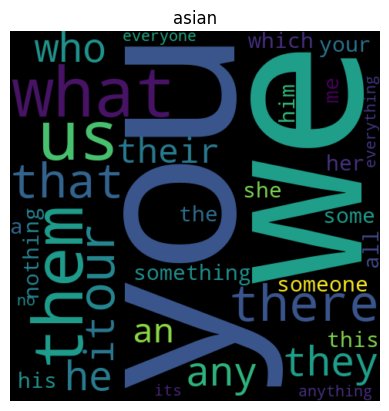

In [250]:
word_cloud = wordcloud.WordCloud(width=480, height=480, margin=0).generate_from_frequencies(alice_hate_pron_frequencies)

# Display the generated image:
plt.title('asian')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()